This code solves the Burger equation using PINNs

$$
\frac{\partial u}{\partial t} + c u \frac{\partial u}{\partial x} = a \frac{\partial^2 u}{\partial t ^2}
$$

It is a well-documented implemmentation of a nonlinear PDE. All other PDE codes have a similar structure

Note: This code works for both CPU and GPU, but will use the GPU automatically if it is available.

In [113]:
# NN libraries
import torch
import torch.nn as nn

# Libraries for solving PDE numerically and plotting
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import diags
from scipy.sparse.linalg import factorized
from scipy.optimize import fsolve

In [114]:
# Checks if GPU is available

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cpu


In [115]:
# Some global settings

# Random seed for Torch and NumPy
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

def sin(x):
    """
    sin function that works with both PyTorch tensors and NumPy arrays.
    """
    if isinstance(x, torch.Tensor): 
        return torch.sin(x)
    else:
        return np.sin(x)

def exp(x):
    """
    exponential function that works with both PyTorch tensors and NumPy arrays.
    """
    if isinstance(x, torch.Tensor): 
        return torch.exp(x)
    else:
        return np.exp(x)

# Creates used directories if they do not exist.
from pathlib import Path
directories = ["gifs", "PINN_plots", "plots"]
for d in directories:
    plots_dir = Path(d)
    plots_dir.mkdir(exist_ok=True)
    print(f"Directory '{plots_dir}' is present. ✅")

Directory 'gifs' is present. ✅
Directory 'PINN_plots' is present. ✅
Directory 'plots' is present. ✅


In [116]:
# Define PDE Parameters

# Domain
xi, xf, dx = 0, 1, 1e-2
ti, tf, dt = 0, 5, 1e-3

# Scales nonlinear wave speed
c  = 1

# Scales diffusion
a  = 1e-2

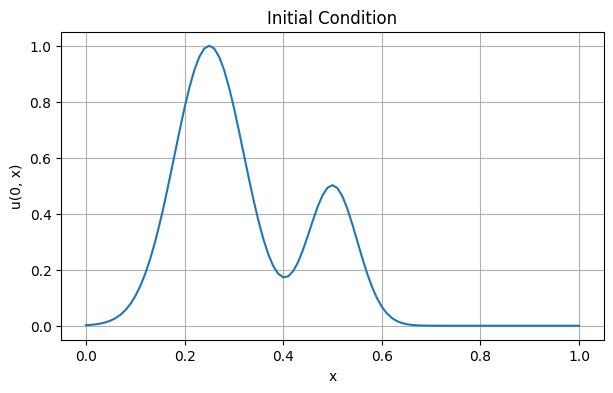

In [117]:
# Initial conditions

x = np.arange(xi, xf + dx, dx, dtype=np.float32)
t = np.arange(ti, tf + dt, dt, dtype=np.float32)
Nx, Nt = len(x), len(t)

def u0(x):
    "Defines u(0, x) as the initial condition"
    return exp(-100*(x-xf/4)**2) + exp(-200*(x-xf/2)**2)*0.5

# Plot the initial condition
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(x, u0(x))
ax.set_xlabel('x')
ax.set_ylabel('u(0, x)')
ax.set_title('Initial Condition')
ax.grid()
plt.show()

In [118]:
# Create matricies for solving PDE
u = np.zeros((Nt, Nx))

def D_t():
    """
    Fourth order finite difference operator for the first derivative in space.
    Periodic boundary conditions are applied.
    """
    d = 1/(12*dx)
    D = d * diags([1, -8, 0, 8, -1], [-2, -1, 0, 1, 2], shape=(Nx, Nx)).toarray()
    D[0, [-2, -1]] = [d, -8*d]
    D[1, [-1]] = [d]
    D[-1, [0, 1]] = [8*d, -d]
    D[-2, [0]] = [-d]
    return sparse.csr_matrix(D)

def D2_t():
    """
    Fourth order finite difference operator for the second derivative in space.
    Periodic boundary conditions are applied.
    """
    d = 1/(12*dx**2)
    D = d * diags([-1, 16, -30, 16, -1], [-2, -1, 0, 1, 2], shape=(Nx, Nx)).toarray()
    D[0, [-2, -1]] = [-d, 16*d]
    D[1, [-1]] = [-d]
    D[-1, [0, 1]] = [16*d, -d]
    D[-2, [0]] = [-d]
    return sparse.csr_matrix(D)

u = np.zeros((Nt, Nx))
I = diags([1], [0], shape=(Nx, Nx))
D1 = D_t()
D2 = D2_t()

def sovler_implicit(ui, uk, D1, D2, dt, c, a):
    """
    Finds current time step solution using the Crank-Nicolson implicit method.
    ui: solution at time step i
    uk: solution at time step i-1
    Returns an impilicit equation. An optimizer will find ui such that res = 0.
    """
    res = ui - uk + dt*0.5*c*(ui*(D1@ui) + uk*(D1@uk)) - dt*0.5*a*(D2@(ui + uk))
    return res.flatten()

def solver_jacobian(ui, uk, D1, D2, dt, c, a):
    """
    Computes the Jacobian of the implicit equation.
    This is used by the optimizer to find the solution.
    """
    J = I - dt*0.5*(c*(diags(D1@ui) + ui*D1) - a*D2)
    return J

Time 0.000s, max u = 1.000
Time 0.100s, max u = 0.840
Time 0.200s, max u = 0.740
Time 0.300s, max u = 0.675
Time 0.400s, max u = 0.632
Time 0.500s, max u = 0.600
Time 0.600s, max u = 0.572
Time 0.700s, max u = 0.548
Time 0.800s, max u = 0.525
Time 0.900s, max u = 0.505
Time 1.000s, max u = 0.485
Time 1.100s, max u = 0.468
Time 1.200s, max u = 0.452
Time 1.300s, max u = 0.438
Time 1.400s, max u = 0.424
Time 1.500s, max u = 0.412
Time 1.600s, max u = 0.401
Time 1.700s, max u = 0.391
Time 1.800s, max u = 0.382
Time 1.900s, max u = 0.373
Time 2.000s, max u = 0.365
Time 2.100s, max u = 0.358
Time 2.200s, max u = 0.352
Time 2.300s, max u = 0.345
Time 2.400s, max u = 0.340
Time 2.500s, max u = 0.334
Time 2.600s, max u = 0.329
Time 2.700s, max u = 0.325
Time 2.800s, max u = 0.321
Time 2.900s, max u = 0.317
Time 3.000s, max u = 0.313
Time 3.100s, max u = 0.309
Time 3.200s, max u = 0.306
Time 3.300s, max u = 0.303
Time 3.400s, max u = 0.300
Time 3.500s, max u = 0.297
Time 3.600s, max u = 0.294
T

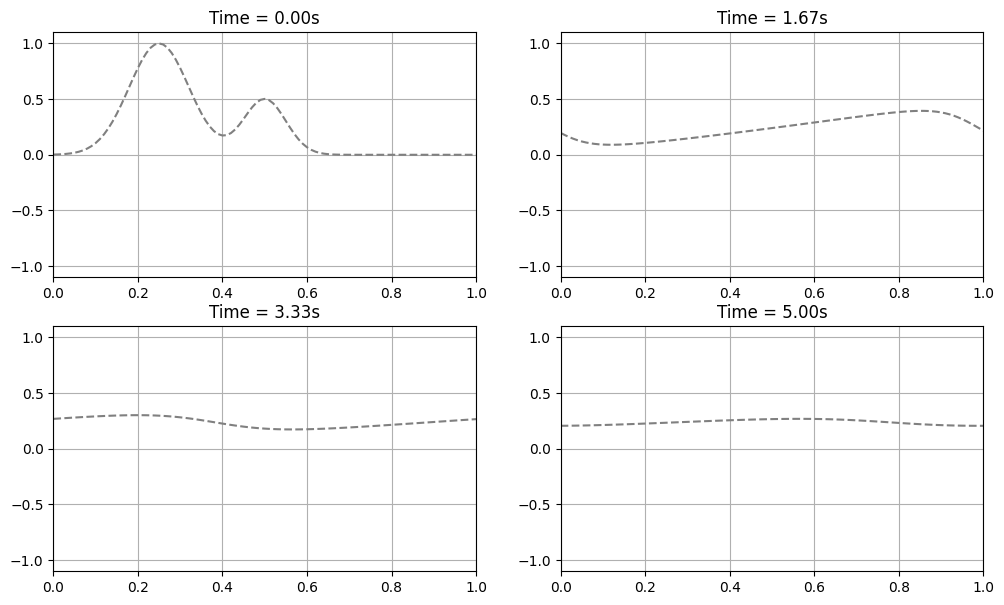

In [119]:
# Numerically Solve PDE wth Crank-Nicolson method

for j, tj in enumerate(t):
    """
    u[j, :]        is the solution at time t[j]
    uk = u[j-1, :] is the solution at time t[j-1]
    """
    if j == 0:
        u[0, :] = u0(x)
    else:
        uk      = u[j-1, :]
        u[j, :] = fsolve(sovler_implicit, uk, args=(uk, D1, D2, dt, c, a),
                         fprime = solver_jacobian, xtol=1e-5)
    if j % int(1/dt * 1e-1) == 0:
        # Prints the time and maximum value of u at that time step
        # For monitoring solution progress and making sure the solution does not blow up
        print(f"Time {tj:.3f}s, max u = {np.max(np.abs(u[j, :])):.3f}")


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))
time_indecies = torch.linspace(0, Nt-1, 4, dtype=int)
for j, ax in enumerate(axs.flat):
    tj = time_indecies[j]
    ax.plot(x, u[tj, :], c="gray", linestyle='--')
    ax.set_title(f"Time = {t[tj]:.2f}s")
    ax.grid()
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(xi, xf)

plt.show()

In [120]:
# Define PINN architecture

class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        
        self.fcs   = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN),activation()])
        self.fch   = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)])
        self.fce   = nn.Linear(N_HIDDEN, N_OUTPUT)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight) 
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [121]:
# Function to plot the training progresss

def training_plot(save=False, file_name=""):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))
    titles = ['t = 0', 't=0.25', 't = 0.5', 't = 1']
    plot_indecies = torch.linspace(0, Nt-1, 4, dtype=int)
    for j, ax in enumerate(axs.flat):
        index = plot_indecies[j]
        ax.plot(x, p[index, :], c='blue')
        ax.plot(x, u[index, :], c="gray", linestyle='--')
        ax.set_title(f"Time = {t[index]:.2f}s")
        ax.grid()
        ax.set_ylim(-1.1, 1.1)
        ax.set_xlim(xi, xf)
        if w_boundary != 0:
            ax.scatter(boundary1_domain.detach()[0, 1].cpu(), u[index, 0], s=20, color="purple")
            ax.scatter(boundary2_domain.detach()[0, 1].cpu(), u[index, -1], s=20, color="purple", label="Boundary Condition")
        if w_PDE != 0:
            ax.scatter(x_col.cpu(), torch.zeros_like(x_col).cpu(), color="green", label="Colocation Points", s=5)
        
        if all([j != 0, t[index] < t_data[-1]]):
            # Note: if the black dots show up, that does not mean the model is being trained on the data for this partular time step.
            # Rather, its a visualization that shows how the training data is being distributed over space, and tells you that the current
            # time step is within the time-range of the training data/
            # TLDR; if black dots show up on t=2s, that does not mean that u(2, x) is being used for training, rahter the time range of of the training
            # data is larger than 2s.
            ax.scatter(x_data.cpu(), u[plot_indecies[j], x_indecies.cpu()], color="black", s=10, label="Training Data")
    
    axs[0, 0].scatter(initial_x.cpu(), u0(initial_x).cpu(), color="red", s=10, label="Initial Condition")
    fig.suptitle(f"Epoch: {i}")
    axs[0,0].legend()
    axs[0,1].legend()
    
    if save:
        fig.savefig(file_name, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")


def plot_loss():
    fig, ax = plt.subplots(figsize=(10, 4))
    lw = 1
    ax.set_title("Loss curve for Neural Network")
    ax.plot(loss_history, label="Total loss", c="blue")
    ax.plot(initial_loss_history, label="Initial loss", c="red", lw=lw)
    ax.plot(boundary_loss_history, label="Boundary loss", c="purple", lw=lw)
    ax.plot(data_loss_history, label="Data loss", c="black", lw=lw)
    ax.plot(pde_loss_history, label="PDE loss", c="green", lw=lw)
    ax.set_xlabel("Epochs")
    ax.set_yscale("log")
    ax.set_xlim(0, epochs)
    ax.legend(loc=(1.01, 0.6))
    ax.grid()

In [122]:
# Define PINN Hyperparameters

learning_rate = 1e-3
epochs        = 50_000 + 1
weights = [w_initial, w_data, w_boundary, w_PDE] = [1e0, 1e0, 1e0, 1e0]

N_initial  = 50
N_boundary = 50
N_training_t = 20
N_training_x = 20
N_col      = 100

N_layers = 6
N_nodes  = 32

In [123]:
# Domains for Training

# Domain for initial condition
initial_x = torch.linspace(xi, xf, N_initial).to(device)
initial_t = torch.zeros(N_initial).to(device)
initial_domain = torch.stack((initial_t, initial_x), dim=1)
initial_u = u0(initial_x).view(-1,1)

# Domain for boundary condition
boundary1_domain = torch.stack((torch.linspace(ti, tf, N_boundary),  x[0]*torch.ones(N_boundary)), dim=1).requires_grad_(True).to(device)
boundary2_domain = torch.stack((torch.linspace(ti, tf, N_boundary), x[-1]*torch.ones(N_boundary)), dim=1).requires_grad_(True).to(device)

# Domain for training data
t_indecies = torch.linspace(1, 1*(Nt-1)//4, N_training_t, dtype=int).to(device) # Defined in terms of indecies to make getting u and corresponding (t,x) values easier
x_indecies = torch.linspace(1, Nx-1, N_training_x, dtype=int).to(device)
Ti_mat, Xi_mat = torch.meshgrid(t_indecies, x_indecies, indexing='ij')

t_data = (torch.from_numpy(t).to(device))[t_indecies]
x_data = (torch.from_numpy(x).to(device))[x_indecies]
Td, Xd = torch.meshgrid(t_data, x_data, indexing='ij')
training_domain = torch.stack((Td.flatten(), Xd.flatten()), dim=1) # (t, x) values that correspond to the u values used for training
training_u      = (torch.from_numpy(u).to(device))[Ti_mat, Xi_mat].view(-1,1)   # Values of u used in training

# Domain for collocation points
t_col  = torch.linspace(ti, tf, N_col).to(device)
x_col  = torch.linspace(xi, xf, N_col).to(device)
Tc, Xc = torch.meshgrid(t_col, x_col, indexing='ij')
colocation_domain = torch.stack((Tc.flatten(), Xc.flatten()), dim=1).requires_grad_(True)

# Domain for Error calculation
T, X = torch.meshgrid(torch.from_numpy(t).to(device), torch.from_numpy(x).to(device), indexing='ij')
input_Domain = torch.stack((T.flatten(), X.flatten()), dim=1)

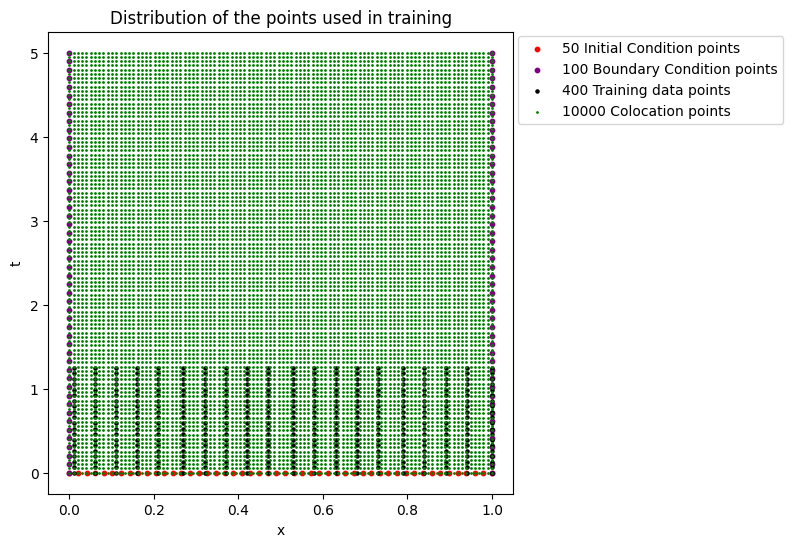

In [124]:
fig, ax = plt.subplots(figsize=(6, 6))

if w_initial != 0:
    ax.scatter(initial_x.cpu(), initial_t.cpu(), s=10, color="Red", label=f"{N_initial} Initial Condition points")
if w_boundary != 0:
    ax.scatter(boundary1_domain.detach()[:,1].cpu(), boundary1_domain.detach()[:,0].cpu(), s=10, color="purple")
    ax.scatter(boundary2_domain.detach()[:,1].cpu(), boundary2_domain.detach()[:,0].cpu(), s=10, color="purple", label=f"{2*N_boundary} Boundary Condition points")
if w_data != 0:
    ax.scatter(training_domain[:,1].cpu(), training_domain[:,0].cpu(), s= 5, color="black", label=f"{len(training_domain)} Training data points")
if w_PDE != 0:
    ax.scatter(colocation_domain.detach()[:,1].cpu(), colocation_domain.detach()[:,0].cpu(), s=1, color="green", label=f"{N_col**2} Colocation points", zorder=1)
    
ax.legend(loc=(1.01, 0.8))
ax.set_ylabel("t")
ax.set_xlabel("x")
ax.set_title("Distribution of the points used in training")
plt.show()

Epoch: 0, Loss: 4.2305e-01, Learning rate = 1.0000e-03


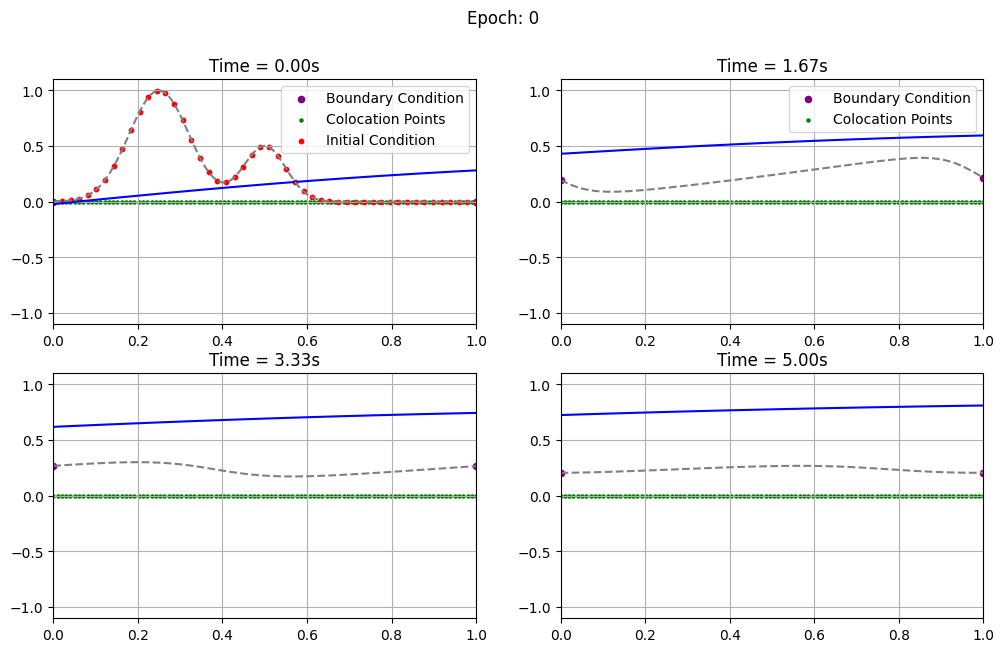

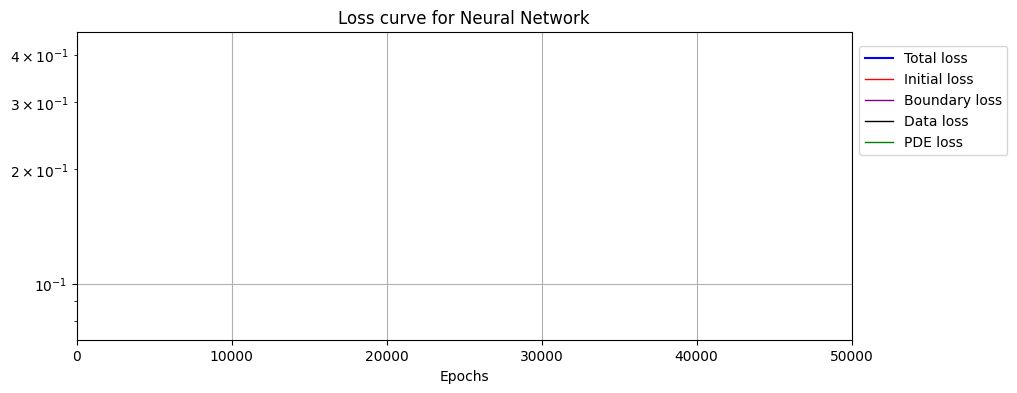

Epoch: 100, Loss: 1.1605e-01, Learning rate = 1.0000e-03


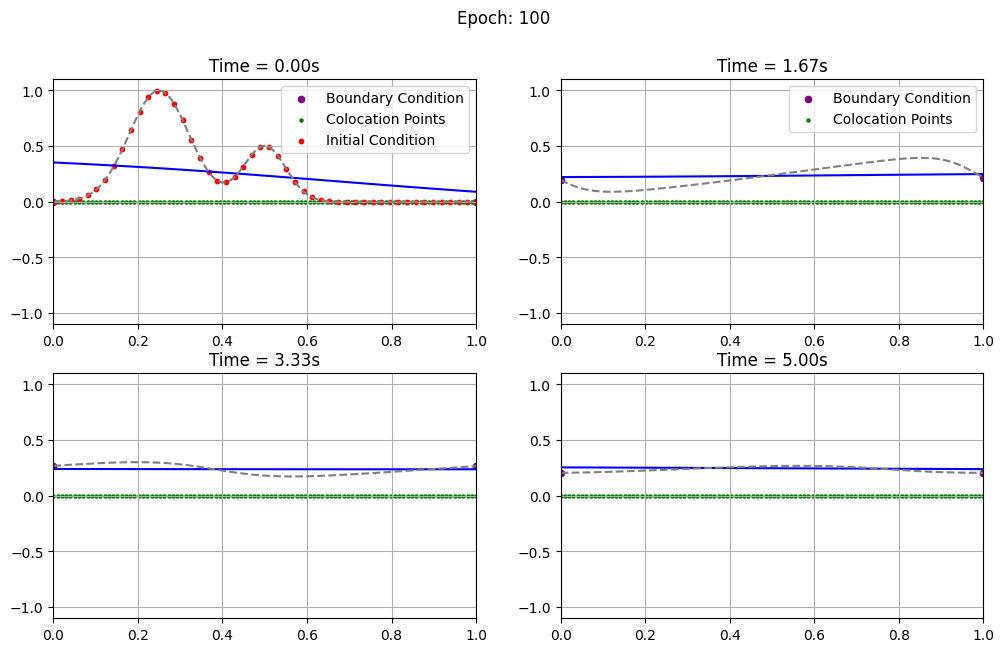

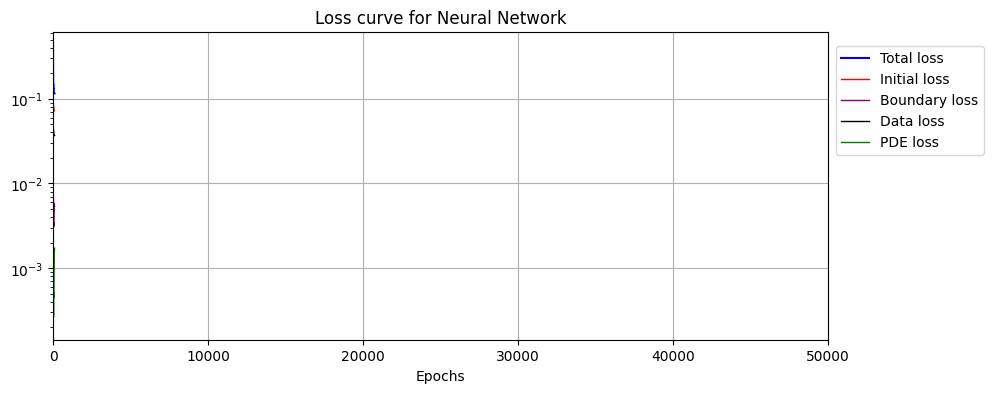

Epoch: 200, Loss: 5.4822e-02, Learning rate = 1.0000e-03
Epoch: 300, Loss: 3.4161e-02, Learning rate = 1.0000e-03
Epoch: 400, Loss: 2.7984e-02, Learning rate = 1.0000e-03
Epoch: 500, Loss: 2.3481e-02, Learning rate = 1.0000e-03
Epoch: 600, Loss: 2.0901e-02, Learning rate = 1.0000e-03


In [ ]:
# Neural Network without physics

Burgers_PINN = FCN(2, 1, N_nodes, N_layers).to(device) # 2 inputs and 1 output since u: RxR -> R, u: (t,x)|->u(t,x)
optimizer    = torch.optim.Adam(Burgers_PINN.parameters(), lr=learning_rate) # Using the Adam optimizer
scheduler    = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.9, patience=100, min_lr=1e-7, threshold=1e-6)

mse_history  = []
loss_history = []
pde_loss_history  = []
data_loss_history = []
initial_loss_history  = []
boundary_loss_history = []


for i in range(epochs):
    Burgers_PINN.train()
    optimizer.zero_grad()
    
    # Initial Loss
    initial_p    = Burgers_PINN(initial_domain)
    loss_initial = torch.mean((initial_p - initial_u)**2)
    
    # Boundary Loss
    b1 = Burgers_PINN(boundary1_domain)
    b2 = Burgers_PINN(boundary2_domain)
    
    Db1 = torch.autograd.grad(b1, boundary1_domain, torch.ones_like(b1), create_graph=True)[0]
    Db2 = torch.autograd.grad(b2, boundary2_domain, torch.ones_like(b2), create_graph=True)[0]
    b1_x = Db1[:, 1:2]
    b2_x = Db2[:, 1:2]
    loss_boundary = torch.mean((b1 - b2)**2 + (b1_x - b2_x)**2)
    
    # Data Loss
    s = Burgers_PINN(training_domain)
    loss_data = torch.mean((s - training_u)**2)
    
    # Physics Loss
    v  = Burgers_PINN(colocation_domain)
    Dv = torch.autograd.grad(v, colocation_domain, torch.ones_like(v), create_graph=True)[0]
    
    v_t  = Dv[:, 0:1]
    v_x  = Dv[:, 1:2]
    
    Dv_x = torch.autograd.grad(v_x, colocation_domain, torch.ones_like(v_x), create_graph=True)[0]
    v_xx = Dv_x[:, 1:2]
    
    loss_PDE = torch.mean((v_t + c*v*v_x - a*v_xx)**2)

    # Total Loss
    losses  = [loss_initial.item(), loss_data.item(), loss_boundary.item(), loss_PDE.item()]

    loss  = weights[0]*loss_initial + weights[1]*loss_data + weights[2]*loss_boundary + weights[3]*loss_PDE
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    Burgers_PINN.eval()
    
    loss_history.append(loss.item())
    initial_loss_history.append(losses[0])
    data_loss_history.append(losses[1])
    boundary_loss_history.append(losses[2])
    pde_loss_history.append(losses[3])
    
    if i % 100 == 0:
        print(f"Epoch: {i}, Loss: {loss.item():.4e}, Learning rate = {optimizer.param_groups[0]['lr']:.4e}")
        if any([i % 5000 == 0, i == 100, i == epochs - 1]):
            P = Burgers_PINN(input_Domain).detach()
            p = P.cpu().numpy().reshape(Nt, Nx)
            if i == epochs - 1:
                training_plot()
                plot_loss()
                plt.show()
            else:
                training_plot()
                plot_loss()
                plt.show()

In [ ]:
import os
import shutil

# Takes the folder PINN_plots and deletes all files and subdirectories in it.
folder_path="PINN_plots"
for item in os.listdir(folder_path):
    item_path = os.path.join(folder_path, item)
    try:
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.unlink(item_path)  # Remove file or symbolic link
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)  # Remove subdirectory and its contents
    except Exception as e:
        print(f"Failed to delete {item_path}. Reason: {e}")

In [ ]:
from PIL import Image

def save_gif_PIL(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=round(1000/fps), loop=loop)

def make_plot(save=False, file_name=f"PDE_solution.png", tk=0):
    fig, ax = plt.subplots()
    ax.plot(x, u[index, :], label='Numerical Solution Solution', linestyle='--', c="black")
    ax.plot(x, p[index, :], label='PINN Solution', c="blue")
    ax.set_xlim(xi, xf)
    ax.set_ylim(-1.05, 1.05)
    ax.grid()
    ax.set_title(f"Time = {tk:.3f}s")
    ax.legend()
    if save:
        fig.savefig(file_name, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")

In [ ]:
files = []
fps   = 20

# Length of gif dpends k*int(fps*t[-1]) where int(fps*t[-1]) makes the gif the length of the timeseries. ie if t[-1] = 2, then the gif will last for 2 seconds.
# k scales that length. So k=2 and t[-1] = 2 will make the gif last for 4 seconds.

frame_indicies = np.linspace(0, Nt-1, 2*int(fps*t[-1]), dtype=int)

N_frames = len(frame_indicies)
for i, index in enumerate(frame_indicies):
    tj = t[index]
    file = f"PINN_plots/PDE_sol_{tj:.5f}.png"
    make_plot(save=True, file_name=file, tk=tj)
    files.append(file)
    plt.close("all")
    print(f"{i}/{N_frames}")
    
save_gif_PIL("gifs/Burgers_PINN_Comparison.gif", files, fps=fps, loop=0)

0/200
1/200
2/200
3/200
4/200
5/200
6/200
7/200
8/200
9/200
10/200
11/200
12/200
13/200
14/200
15/200
16/200
17/200
18/200
19/200
20/200
21/200
22/200
23/200
24/200
25/200
26/200
27/200
28/200
29/200
30/200
31/200
32/200
33/200
34/200
35/200
36/200
37/200
38/200
39/200
40/200
41/200
42/200
43/200
44/200
45/200
46/200
47/200
48/200
49/200
50/200
51/200
52/200
53/200
54/200
55/200
56/200
57/200
58/200
59/200
60/200
61/200
62/200
63/200
64/200
65/200
66/200
67/200
68/200
69/200
70/200
71/200
72/200
73/200
74/200
75/200
76/200
77/200
78/200
79/200
80/200
81/200
82/200
83/200
84/200
85/200
86/200
87/200
88/200
89/200
90/200
91/200
92/200
93/200
94/200
95/200
96/200
97/200
98/200
99/200
100/200
101/200
102/200
103/200
104/200
105/200
106/200
107/200
108/200
109/200
110/200
111/200
112/200
113/200
114/200
115/200
116/200
117/200
118/200
119/200
120/200
121/200
122/200
123/200
124/200
125/200
126/200
127/200
128/200
129/200
130/200
131/200
132/200
133/200
134/200
135/200
136/200
137/200
138/20